# Sparkify - A churn analysis by predicting model

This notebook uses a toy dataset (128MB) made by udacity to analysis churn for a supposed music app called sparkify. The dataset is a log for the events made by the users in the app.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType, DateType
from pyspark.sql.functions import count, when, col, desc, asc, from_unixtime, datediff
from pyspark.sql.functions import sum as Fsum
from matplotlib import pyplot as plt

import datetime

import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Predicting churn') \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'Predicting churn'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '3f543ff79b26'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'local-1635461936430'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '37203')]

# Load and Clean Dataset
In this notebook, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [4]:
path = 'mini_sparkify_event_data.json'
user_log = spark.read.json(path)

# Exploratory Data Analysis

### Define Churn

Churn is defined in this case using the event “Cancellation Confirmation”. So let’s create a column to the user's ID and another to say if this user canceled the service of music streaming or not. 

In [5]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
user_log.createOrReplaceTempView('user_log_table')

In [7]:
spark.sql('''
            SELECT * 
            FROM user_log_table
            LIMIT 2
            '''
         ).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9


In [8]:
spark.sql('''
            SELECT userID, auth, level, location, page, song, status
            FROM user_log_table
            WHERE userID = 30
            '''
         ).toPandas()

,userID,auth,level,location,page,song,status
0,30,Logged In,paid,"Bakersfield, CA",NextSong,Rockpools,200
1,30,Logged In,paid,"Bakersfield, CA",NextSong,Time For Miracles,200
2,30,Logged In,paid,"Bakersfield, CA",NextSong,Harder Better Faster Stronger,200
3,30,Logged In,paid,"Bakersfield, CA",NextSong,Passengers (Old Album Version),200
4,30,Logged In,paid,"Bakersfield, CA",Add to Playlist,None,200
5,30,Logged In,paid,"Bakersfield, CA",NextSong,Fuck Kitty,200
6,30,Logged In,paid,"Bakersfield, CA",NextSong,Jade,200
7,30,Logged In,paid,"Bakersfield, CA",NextSong,So-Called Friends,200
8,30,Logged In,paid,"Bakersfield, CA",NextSong,Represent,200
9,30,Logged In,paid,"Bakersfield, CA",NextSong,Here I Am,200


In [9]:
# Displaying all the possible events a user could do
spark.sql('''
            SELECT DISTINCT(page)
            FROM user_log_table
            '''
         ).collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [10]:
df_churn = spark.sql('''
                    SELECT userID, SUM(isChurn) AS isChurn
                    FROM (
                        SELECT userID,
                            CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END AS isChurn
                        FROM user_log_table
                        )
                    GROUP BY 1
                ''')

In [11]:
df_churn.toPandas().head()

,userID,isChurn
0,100010,0
1,200002,0
2,125,1
3,51,1
4,124,0


### Explore Data
Let's do some exploratory data analysis to observe the behavior for users who stayed vs users who churned.

In [12]:
# Total log registers
spark.sql('''
            SELECT COUNT(*) 
            FROM user_log_table
            '''
         ).show()

+--------+
|count(1)|
+--------+
|  286500|
+--------+



In [13]:
# Total of unique users
spark.sql('''
            SELECT COUNT(DISTINCT(userID)) 
            FROM user_log_table
            '''
         ).show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   226|
+----------------------+



In [14]:
# Display all types of auth
spark.sql('''
            SELECT DISTINCT(auth) 
            FROM user_log_table
            '''
         ).show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [15]:
# Understanding the log of Guest users
spark.sql('''
            SELECT userID, auth, level, location, page, song, status
            FROM user_log_table
            WHERE auth = "Guest"
            '''
         ).toPandas().head(20)

,userID,auth,level,location,page,song,status
0,,Guest,free,None,Error,None,404
1,,Guest,free,None,Home,None,200
2,,Guest,free,None,Register,None,200
3,,Guest,free,None,Help,None,200
4,,Guest,free,None,Home,None,200
5,,Guest,free,None,About,None,200
6,,Guest,free,None,Register,None,200
7,,Guest,free,None,Home,None,200
8,,Guest,free,None,Register,None,200
9,,Guest,free,None,Help,None,200


In [16]:
# Display all pages allowed to access by Guest users
spark.sql('''
            SELECT DISTINCT(page) 
            FROM user_log_table
            WHERE auth = "Guest"
            '''
         ).show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|           Register|
|               Help|
|              Error|
+-------------------+



The userID field is empty for Guest users, and we can see that this type of user can't use the full services available. So lt's clear the data set, dropping all records without userId and sessionId, since one identifies the user and the other is used by HTTP protocol to network communications, being extremely necessary to provide services for the logged users.

In [17]:
# Total registers before cleaning
spark.sql('''
            SELECT COUNT(*) 
            FROM user_log_table
            '''
         ).show()

+--------+
|count(1)|
+--------+
|  286500|
+--------+



In [18]:
# Total registers after cleaning
spark.sql('''
            SELECT COUNT(*) 
            FROM user_log_table
            WHERE userID <> '' AND sessionID IS NOT NULL
            '''
         ).show()

+--------+
|count(1)|
+--------+
|  278154|
+--------+



In [19]:
valid_log = spark.sql('''
                        SELECT * 
                        FROM user_log_table
                        WHERE userID <> '' AND sessionID IS NOT NULL
                        '''
                     )
valid_log.createOrReplaceTempView('clean_user_log_table')

In [20]:
# How many users canceled the streaming music service?
df_churn.createOrReplaceTempView('churn_user_table')
df_churn = spark.sql('''
                        SELECT * 
                        FROM churn_user_table
                        WHERE userID <> ''
                        '''
                     )

df_churn.createOrReplaceTempView('churn_user_table')
spark.sql('''
            SELECT COUNT(*)
            FROM churn_user_table
            WHERE isChurn = 1
            '''
         ).show()

+--------+
|count(1)|
+--------+
|      52|
+--------+



In [21]:
# Total distinct users
spark.sql('''
            SELECT COUNT(*)
            FROM churn_user_table
            '''
         ).show()

+--------+
|count(1)|
+--------+
|     225|
+--------+



In [22]:
spark.sql('''
            SELECT DISTINCT level
            FROM clean_user_log_table
            '''
         ).show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



Considering that we have two groups: users who canceled the streaming music service and users who stayed. How many of the users are free and paid by each of these groups? Let's see if a user could have the two levels assigned.

In [23]:
spark.sql('''
            SELECT userID, COUNT(DISTINCT level) level
            FROM clean_user_log_table
            GROUP BY 1
            ORDER BY 1
            '''
         ).toPandas().head(20)

,userID,level
0,10,1
1,100,2
2,100001,1
3,100002,1
4,100003,1
5,100004,2
6,100005,1
7,100006,1
8,100007,1
9,100008,2


At the above, we can see users with two levels registered in the log. So let’s get the last register in the log for each user to label a user as paid or free.

In [24]:
valid_log = valid_log.withColumn('occurred_at', from_unixtime((col('ts')/1000), 'yyyy-MM-dd HH:mm:ss'))
valid_log.createOrReplaceTempView('clean_user_log_table')

In [25]:
level_churn = spark.sql('''
            SELECT DISTINCT(a.userID), b.lastAccess, a.level, c.isChurn
            FROM clean_user_log_table AS a
            RIGHT JOIN (
                SELECT userID,
                    MAX(occurred_at) lastAccess
                FROM clean_user_log_table
                GROUP BY 1
            ) AS b
            ON a.userID = b.userID AND a.occurred_at = b.lastAccess
            JOIN churn_user_table c
            ON c.userID = a.userID
            ORDER BY 1
            '''
         )

In [26]:
level_churn.toPandas().head(20)

,userID,lastAccess,level,isChurn
0,10,2018-11-19 12:49:48,paid,0
1,100,2018-11-30 14:15:49,paid,0
2,100001,2018-10-02 16:36:45,free,1
3,100002,2018-12-03 01:11:16,paid,0
4,100003,2018-10-11 16:19:41,free,1
5,100004,2018-11-29 02:37:45,paid,0
6,100005,2018-10-19 17:57:05,free,1
7,100006,2018-10-05 15:24:30,free,1
8,100007,2018-11-29 11:45:09,paid,1
9,100008,2018-11-27 16:13:39,free,0


In [27]:
# Counting how many users paid and free are in the two groups?
level_churn.createOrReplaceTempView('level_churn_table')
level_df = spark.sql('''
            SELECT isChurn, SUM(paid) AS paid, SUM(free) as free
            FROM (
                SELECT userID, isChurn,
                        (CASE WHEN level = "paid" THEN 1 ELSE 0 END) AS paid,                    
                        (CASE WHEN level = "free" THEN 1 ELSE 0 END) AS free
                FROM level_churn_table)
            GROUP BY 1
            '''
         ).toPandas()
level_df

,isChurn,paid,free
0,0,114,59
1,1,31,21


In [28]:
# Converting theses values in percentage
level_df.loc[0] = level_df.loc[0] * 100 / np.sum(level_df.loc[0])
level_df.loc[1] = level_df.loc[1] * 100 / np.sum(level_df.loc[1])
level_df.drop('isChurn', axis=1, inplace=True)
level_df.set_index(pd.Index(['Stayed', 'Canceled']), inplace=True)
level_df

,paid,free
Stayed,65.895954,34.104046
Canceled,58.490566,39.622642


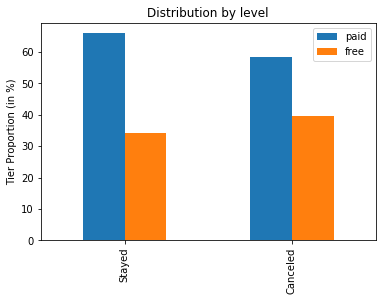

In [29]:
level_df[['paid', 'free']].plot(kind='bar', title='Distribution by level')
plt.ylabel('Tier Proportion (in %)');

We can see that free users are bit more susceptible to churn than paid users. Could the advertising average by session be related to it? 

In [30]:
spark.sql('''
            SELECT a.userID, a.advertising, b.level, b.isChurn
            FROM (
                SELECT userID,
                        SUM(CASE WHEN page = "Roll Advert" THEN 1 ELSE 0 END) AS advertising
                FROM clean_user_log_table
                GROUP BY 1
                ) AS a
            JOIN level_churn_table AS b
            ON a.userID = b.userID
            ORDER BY advertising DESC
            '''
         ).toPandas().head(20)

,userID,advertising,level,isChurn
0,39,128,paid,0
1,200023,116,paid,0
2,100022,115,free,1
3,140,87,paid,0
4,100004,86,paid,0
5,92,85,free,0
6,100018,80,free,0
7,13,74,free,0
8,30,72,paid,0
9,100015,69,paid,1


Since a user could downgrade or upgrade the service, the same user could have two phases in the log: the free and paid, whereas the “canceled confirmation” could happen in one of these phases. So, let’s separate the answer in these two phases: free and paid.

In [31]:
free_ad_dist = spark.sql('''
            SELECT userID, AVG(advertising) avg_advertising, isChurn
            FROM (
                SELECT userID, sessionID,
                     SUM(CASE WHEN page = "Roll Advert" THEN 1 ELSE 0 END) AS advertising,
                     SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                WHERE level = "free"
                GROUP BY 1, 2
                )
            GROUP BY 1, 3
            ORDER BY 3 DESC, 2 DESC
            ''').toPandas()

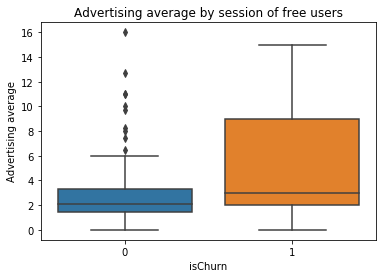

In [32]:
# visualize the distribution of advertising average by session of free users for both groups
sns.boxplot(y="avg_advertising", x="isChurn", data=free_ad_dist)
plt.title('Advertising average by session of free users')
plt.ylabel('Advertising average')
plt.show()

In [33]:
paid_ad_dist = spark.sql('''
            SELECT userID, AVG(advertising) avg_advertising, isChurn
            FROM (
                SELECT userID, sessionID,
                     SUM(CASE WHEN page = "Roll Advert" THEN 1 ELSE 0 END) AS advertising,
                     SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                FROM clean_user_log_table
                WHERE level = "paid"
                GROUP BY 1, 2
                )
            GROUP BY 1, 3
            ORDER BY 3 DESC, 2 DESC
            ''').toPandas()

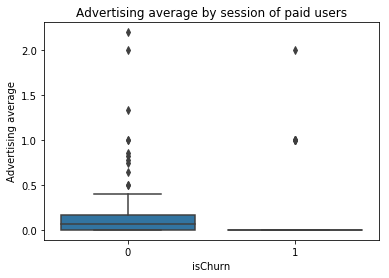

In [34]:
# visualize the distribution of advertising average by session of paid users for both groups
sns.boxplot(y="avg_advertising", x="isChurn", data=paid_ad_dist)
plt.title('Advertising average by session of paid users')
plt.ylabel('Advertising average')
plt.show()

It’s possible to understand from the above boxplot, that advertising average by session could be an indicator to predict churn especifically for free users. Let’s find out if “downgrade” page could be either related to churn.

In [35]:
paid_downgrade = spark.sql('''
                SELECT userID, AVG(downgradeAmt) avg_downgrade, isChurn
                FROM (
                    SELECT userID, sessionID,
                         SUM(CASE WHEN page = "Downgrade" THEN 1 ELSE 0 END) AS downgradeAmt,
                         SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                    FROM clean_user_log_table
                    WHERE level = "paid"
                    GROUP BY 1, 2
                    )
                GROUP BY 1, 3
                ORDER BY 3 DESC, 2 DESC
            '''
        ).toPandas()

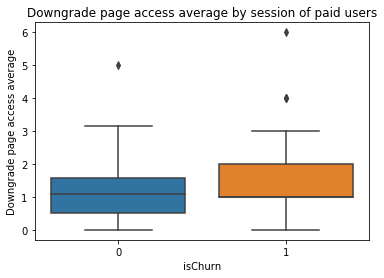

In [36]:
# visualize the distribution of downgrade page access average by session of paid users for both groups
sns.boxplot(y="avg_downgrade", x="isChurn", data=paid_downgrade)
plt.title('Downgrade page access average by session of paid users')
plt.ylabel('Downgrade page access average')
plt.show()

In [37]:
spark.sql('''
                SELECT userID, AVG(downgradeAmt) avg_downgrade, isChurn
                FROM (
                    SELECT userID, sessionID,
                         SUM(CASE WHEN page = "Downgrade" THEN 1 ELSE 0 END) AS downgradeAmt,
                         SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                    FROM clean_user_log_table
                    WHERE level = "free"
                    GROUP BY 1, 2
                    )
                GROUP BY 1, 3
                ORDER BY 3 DESC, 2 DESC
            '''
        ).toPandas().head()

,userID,avg_downgrade,isChurn
0,100011,0.0,1
1,100024,0.0,1
2,100006,0.0,1
3,100025,0.0,1
4,100022,0.0,1


The above graph does not give strong arguments to affirme downgrade page access average by session of paid users could be a good indicator. Free users don't have access to the downgrade page, according to the data. Could the Thumbs up or Thumbs down action average by session be interpreted as a good indicator for our model?

In [38]:
thumbsUp = spark.sql('''
                SELECT userID, AVG(thumbsUpAmt) avg_thumbsUp, isChurn
                FROM (
                    SELECT userID, sessionID,
                         SUM(CASE WHEN page = "Thumbs Up" THEN 1 ELSE 0 END) AS thumbsUpAmt,
                         SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                    FROM clean_user_log_table
                    GROUP BY 1, 2
                    )
                GROUP BY 1, 3
                ORDER BY 3 DESC, 2 DESC
            '''
        ).toPandas()

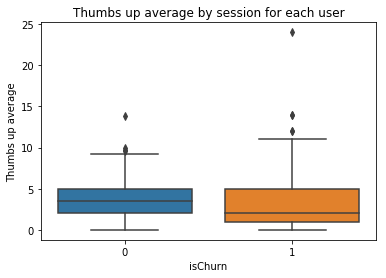

In [39]:
# visualize the distribution of thumbs up average by session for each user for both groups
sns.boxplot(y="avg_thumbsUp", x="isChurn", data=thumbsUp)
plt.title('Thumbs up average by session for each user')
plt.ylabel('Thumbs up average')
plt.show()

In [40]:
thumbsDown = spark.sql('''
                SELECT userID, AVG(thumbsDownAmt) avg_thumbsDown, isChurn
                FROM (
                    SELECT userID, sessionID,
                         SUM(CASE WHEN page = "Thumbs Down" THEN 1 ELSE 0 END) AS thumbsDownAmt,
                         SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                    FROM clean_user_log_table
                    GROUP BY 1, 2
                    )
                GROUP BY 1, 3
                ORDER BY 3 DESC, 2 DESC
            '''
        ).toPandas()

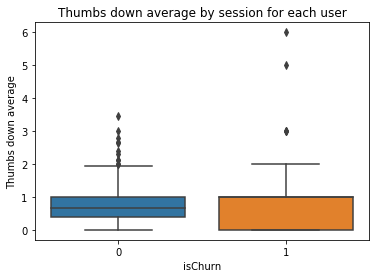

In [41]:
# visualize the distribution of thumbs down average by session for each user for both groups
sns.boxplot(y="avg_thumbsDown", x="isChurn", data=thumbsDown)
plt.title('Thumbs down average by session for each user')
plt.ylabel('Thumbs down average')
plt.show()

We don’t have strong arguments to use these measures as indicators for our model. But if we assume that users who really like this streaming music service and his song recommendations, would accumulate a Thumbs up proportion much greater than Thumbs down. Wouldn't you think? Let's verify for each of the level groups.

In [42]:
proportion_thumbsDown_free = spark.sql('''
                SELECT userID, (thumbsDownAmt / (thumbsUpAmt + thumbsDownAmt)) thumbsDown_proportion, isChurn
                FROM (
                    SELECT userID,
                         SUM(CASE WHEN page = "Thumbs Up" THEN 1 ELSE 0 END) AS thumbsUpAmt,
                         SUM(CASE WHEN page = "Thumbs Down" THEN 1 ELSE 0 END) AS thumbsDownAmt,
                         SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                    FROM clean_user_log_table
                    WHERE level="free"
                    GROUP BY 1
                    )
                ORDER BY 3 DESC, 2 DESC
            '''
        ).toPandas()

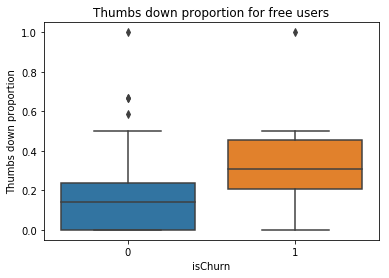

In [43]:
# visualize the distribution of thumbs down proportion for free user by both groups
sns.boxplot(y="thumbsDown_proportion", x="isChurn", data=proportion_thumbsDown_free)
plt.title('Thumbs down proportion for free users')
plt.ylabel('Thumbs down proportion')
plt.show()

In [44]:
proportion_thumbsDown_paid = spark.sql('''
                SELECT userID, (thumbsDownAmt / (thumbsUpAmt + thumbsDownAmt)) thumbsDown_proportion, isChurn
                FROM (
                    SELECT userID,
                         SUM(CASE WHEN page = "Thumbs Up" THEN 1 ELSE 0 END) AS thumbsUpAmt,
                         SUM(CASE WHEN page = "Thumbs Down" THEN 1 ELSE 0 END) AS thumbsDownAmt,
                         SUM(CASE WHEN page = "Cancellation Confirmation" THEN 1 ELSE 0 END) AS isChurn
                    FROM clean_user_log_table
                    WHERE level="paid"
                    GROUP BY 1
                    )
                ORDER BY 3 DESC, 2 DESC
            '''
        ).toPandas()

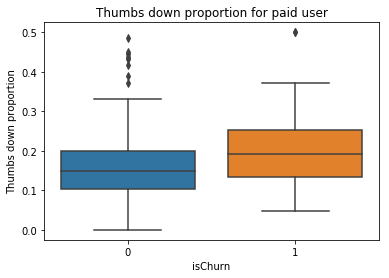

In [45]:
# visualize the distribution of thumbs down proportion for paid user by both groups
sns.boxplot(y="thumbsDown_proportion", x="isChurn", data=proportion_thumbsDown_paid)
plt.title('Thumbs down proportion for paid user')
plt.ylabel('Thumbs down proportion')
plt.show()

Thumbs down proportion for free users plot show us a huge difference between the second and third percentile positions for churn users compared to stayed users, which could indicate that for a Thumbs down proportion above 0.22, we have a higher chance to have a churn. The thumbs down proportion for paid user plot show a tiny difference, which indicates that this factor is not so relevant to determine churn for paid users.

In [46]:
paid_users = spark.sql('''
            SELECT DATE_TRUNC("day", occurred_at) AS day,
                COUNT(DISTINCT userID) AS paidUsers
            FROM clean_user_log_table
            WHERE level = "paid"
            GROUP BY 1
            ORDER BY 1
            '''
         ).toPandas()

free_users = spark.sql('''
            SELECT DATE_TRUNC("day", occurred_at) AS day,
                COUNT(DISTINCT userID) AS freeUsers
            FROM clean_user_log_table
            WHERE level = "free"
            GROUP BY 1
            ORDER BY 1
            '''
         ).toPandas()

In [ ]:
# plotting the 
plt.plot(paid_users['day'], paid_users['paidUsers'], label = "Paid users")
plt.plot(free_users['day'], free_users['freeUsers'], label = "Free users")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
Colocar titulo no gráfico, e Descobrir quantos usuários novos foram adquiridos neste tempo.
Lembrando que o grafico acima se trata de usuarios ativos diariamente na aplicação.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.